TASK 1

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os

# Set up paths and parameters
image_size = (320, 320)
batch_size = 2
epochs = 25


In [25]:
# Paths to your image and mask folders
image_dir = '/content/drive/MyDrive/Image-20240809T121604Z-001/Image'
mask_dir = '/content/drive/MyDrive/Mask-20240809T121619Z-001/Mask'

# Load images and masks
def load_data(image_dir, mask_dir, image_size):
    images = []
    masks = []

    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for img_name, mask_name in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, image_size)

        images.append(img)
        masks.append(mask)

    images = np.array(images) / 255.0  # Normalize images to [0, 1]
    masks = np.array(masks) / 255.0  # Normalize masks to [0, 1]
    masks = np.expand_dims(masks, axis=-1)  # Add channel dimension

    return images, masks

# Load and preprocess data
images, masks = load_data(image_dir, mask_dir, image_size)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.25, random_state=42)


In [26]:
def unet_model(input_size=(320, 320, 3)):
    inputs = tf.keras.Input(input_size)

    # Contracting Path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expanding Path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Instantiate the model
model = unet_model()
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 320, 320, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 320, 320, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 320, 320, 64)   │         36,928 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 160, 160, 64)   │              0 │ conv2d_39[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 160, 160, 128)  │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 160, 160, 128)  │        147,584 │ conv2d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 80, 80, 128)    │              0 │ conv2d_41[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 80, 80, 256)    │        295,168 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 80, 80, 256)    │        590,080 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 40, 40, 256)    │              0 │ conv2d_43[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 40, 40, 512)    │      1,180,160 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 40, 40, 512)    │      2,359,808 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 20, 20, 512)    │              0 │ conv2d_45[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 20, 20, 1024)   │      4,719,616 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 20, 20, 1024)   │      9,438,208 │ conv2d_46[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_8        │ (None, 40, 40, 512)    │      2,097,664 │ conv2d_47[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8        

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def iou(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1) / (union + 1)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[dice_coef, iou])


In [28]:
# Data augmentation
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the flow methods
seed = 1
image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)

# Combine generators into one that yields image and masks
train_generator = zip(image_generator, mask_generator)


In [30]:
# Fit model
history = model.fit((pair for pair in zip(image_generator, mask_generator)), # Convert zip object to a generator expression
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val))

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 181s 25s/step - dice_coef: 0.3287 - iou: 0.1982 - loss: 0.6380 - val_dice_coef: 0.3236 - val_iou: 0.1930 - val_loss: 0.5874
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 161s 25s/step - dice_coef: 0.2726 - iou: 0.1585 - loss: 0.5301 - val_dice_coef: 0.3151 - val_iou: 0.1870 - val_loss: 0.5750
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 167s 24s/step - dice_coef: 0.3199 - iou: 0.1920 - loss: 0.4970 - val_dice_coef: 0.3317 - val_iou: 0.1988 - val_loss: 0.5554
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 154s 22s/step - dice_coef: 0.3206 - iou: 0.1917 - loss: 0.5077 - val_dice_coef: 0.3375 - val_iou: 0.2030 - val_loss: 0.5411
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 153s 22s/step - dice_coef: 0.3897 - iou: 0.2436 - loss: 0.4985 - val_dice_coef: 0.2992 - val_iou: 0.1760 - val_loss: 0.6088
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 165s 24s/step - dice_coef: 0.3333 - iou: 0.2009 - loss: 0.4768 - val_dice_coef: 0.3956 - val_iou: 0.2465 - val_loss: 0.5220
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 160s

In [31]:
# Evaluate on validation data
results = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Dice Coefficient: {results[1]}")
print(f"Validation IoU: {results[2]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - dice_coef: 0.3876 - iou: 0.2404 - loss: 0.4929
Validation Dice Coefficient: 0.3876371383666992
Validation IoU: 0.24041767418384552


1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step


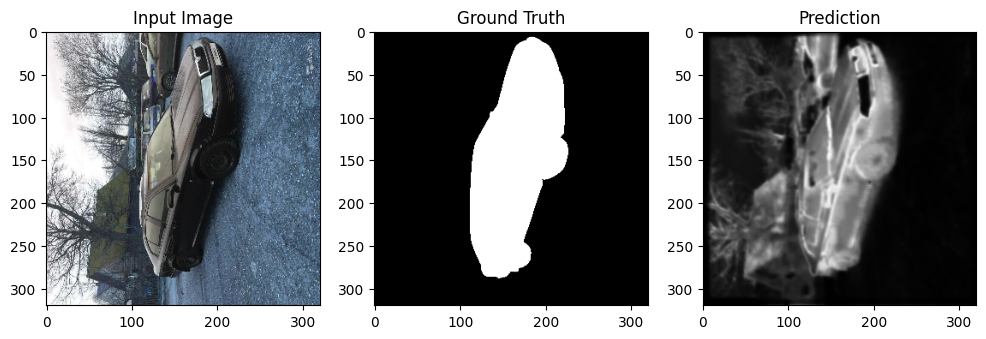

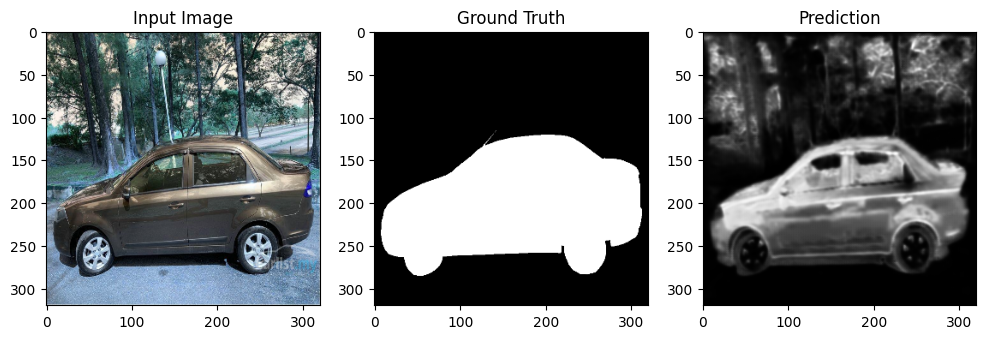

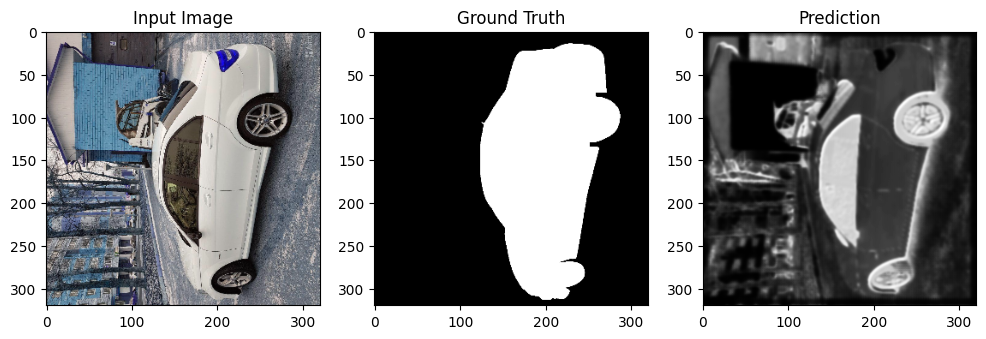

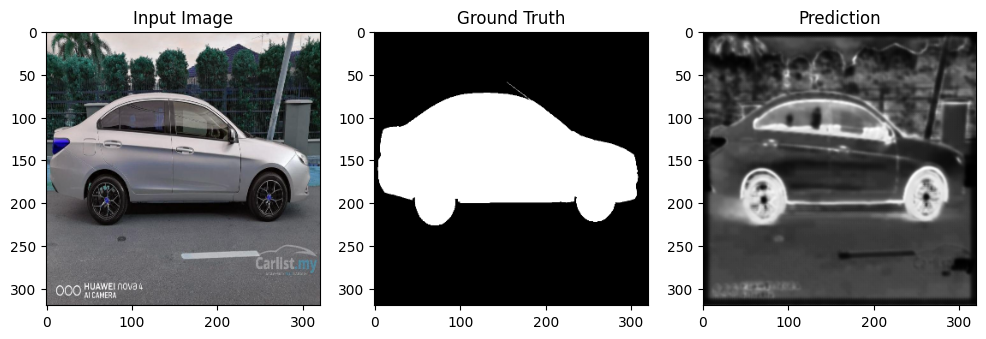

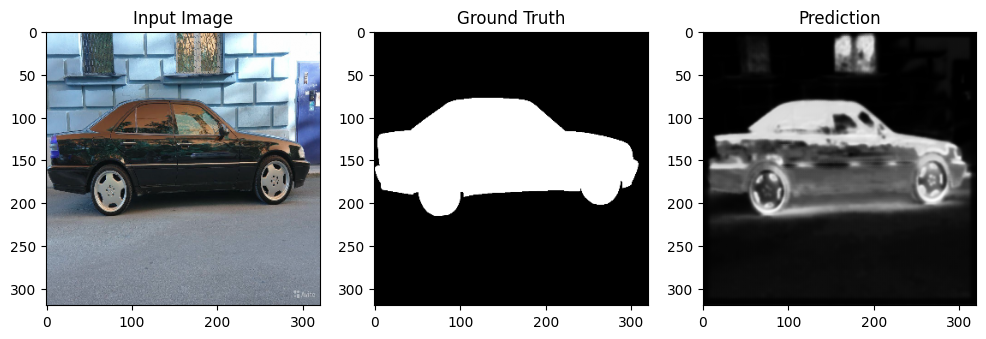

In [33]:
import matplotlib.pyplot as plt
def visualize_predictions(X, y, model):
    predictions = model.predict(X)
    for i in range(len(X)):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(X[i])
        plt.title("Input Image")
        plt.subplot(1, 3, 2)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Prediction")
        plt.show()

visualize_predictions(X_val, y_val, model)



TASK 2


In [34]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred):
    numerator = 2 * K.sum(y_true * y_pred)
    denominator = K.sum(y_true + y_pred)
    return 1 - (numerator + 1) / (denominator + 1)


In [38]:
model.compile(optimizer='adam',
              loss=dice_loss,
              metrics=[dice_coef, iou])



In [40]:
# Fit model with dice_loss
history = model.fit((pair for pair in zip(image_generator, mask_generator)),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val))

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 192s 27s/step - dice_coef: 0.4690 - iou: 0.3084 - loss: 0.5310 - val_dice_coef: 0.6952 - val_iou: 0.5328 - val_loss: 0.3048
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 164s 25s/step - dice_coef: 0.6449 - iou: 0.4925 - loss: 0.3624 - val_dice_coef: 0.5448 - val_iou: 0.3744 - val_loss: 0.4552
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 165s 24s/step - dice_coef: 0.4414 - iou: 0.2869 - loss: 0.5728 - val_dice_coef: 0.5008 - val_iou: 0.3340 - val_loss: 0.4992
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 159s 23s/step - dice_coef: 0.5636 - iou: 0.4041 - loss: 0.4551 - val_dice_coef: 0.5784 - val_iou: 0.4068 - val_loss: 0.4216
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 165s 24s/step - dice_coef: 0.4859 - iou: 0.3255 - loss: 0.5134 - val_dice_coef: 0.4727 - val_iou: 0.3095 - val_loss: 0.5273
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 153s 22s/step - dice_coef: 0.6432 - iou: 0.4783 - loss: 0.3604 - val_dice_coef: 0.5665 - val_iou: 0.3952 - val_loss: 0.4335
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 159s

In [41]:
# Evaluate on validation data
results = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Dice Coefficient: {results[1]}")
print(f"Validation IoU: {results[2]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - dice_coef: 0.4471 - iou: 0.2879 - loss: 0.5529
Validation Dice Coefficient: 0.4471055865287781
Validation IoU: 0.2879182696342468


In [42]:
model.save('u2net_car_segmentation_dice_loss.h5')


TASK 3


In [1]:
from tensorflow.keras.preprocessing.image import load_img

def detect_orientation(image_path):
    img = load_img(image_path, target_size=(320, 320)) # Load image using the imported function
    width, height = img.size
    aspect_ratio = width / height
    return 'Horizontal' if aspect_ratio > 1 else 'Vertical'


# Example usage:
print(detect_orientation('/content/drive/MyDrive/Image-20240809T121604Z-001/Image/1.jpg'))


Vertical


TASK 4

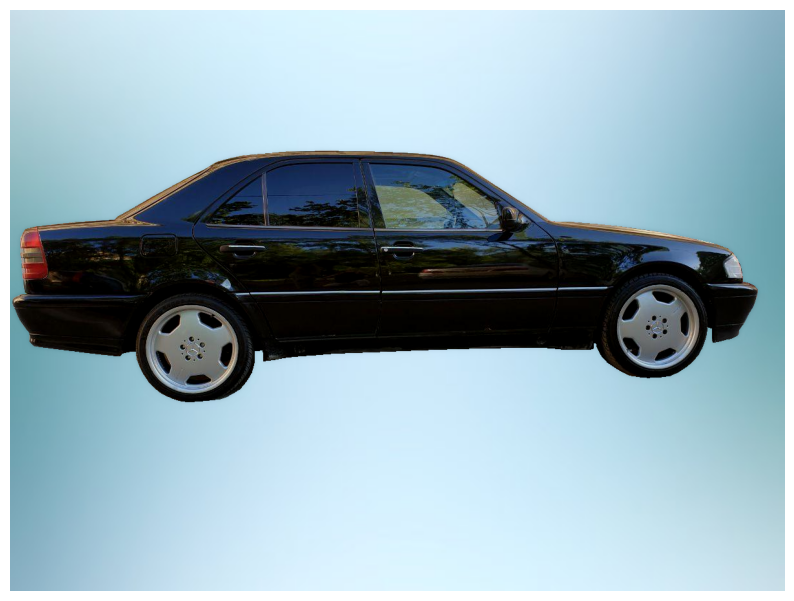

True

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_virtual_background(image, mask, background, shadow=True):
    # Resize background to match the input image
    background = cv2.resize(background, (image.shape[1], image.shape[0]))

    # Ensure mask is binary (0 or 1)
    binary_mask = (mask > 0).astype(np.uint8)

    # Invert mask to cover the background
    inverse_mask = 1 - binary_mask

    # Apply background to areas outside the car
    foreground = image * binary_mask[..., np.newaxis]
    background_area = background * inverse_mask[..., np.newaxis]

    # Combine foreground (car) with the new background
    result = foreground + background_area

    if shadow:
        # Create a shadow by blurring the mask and applying it below the car
        shadow_mask = cv2.GaussianBlur(binary_mask.astype(np.float32), (21, 21), 0)
        shadow_area = shadow_mask * 0.5  # Darken shadow

        # Overlay shadow on result image
        result = result.astype(np.float32)
        result[..., 0] -= shadow_area * 50
        result[..., 1] -= shadow_area * 50
        result[..., 2] -= shadow_area * 50
        result = np.clip(result, 0, 255).astype(np.uint8)

    return result

# Load example images
image = cv2.imread('/content/drive/MyDrive/Image-20240809T121604Z-001/Image/20.jpg')          # Replace with your car image path
mask = cv2.imread('/content/drive/MyDrive/Mask-20240809T121619Z-001/Mask/20.png', 0)         # Replace with your mask path (grayscale)
background = cv2.imread('/content/drive/MyDrive/360_F_310162798_6hWbaSFgDtWp4AhhaKPlTgAZUDL1c4UY.jpg')    # Replace with your background image path

# Apply virtual background and shadow
output_image = apply_virtual_background(image, mask, background)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Optionally save the result
cv2.imwrite('output_with_background.jpg', output_image)
